# Setup

In [3]:
import pandas as pd
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud

In [4]:
pd.set_option('display.max_colwidth',200)

# Load Data

In [8]:
def load_data(file):
    """Load data from a file"""
    with open(file, "r", encoding="utf-8") as data:
        return [line.strip() for line in data]

In [10]:
def load_data_as_df(en_file, nl_file):
    print(f"Loading English Corpora from: {en_file} ...")
    en_corpora = load_data(en_file)
    print(f"Loading Dutch Corpora from: {nl_file} ...")
    nl_corpora = load_data(nl_file)
    return pd.DataFrame({"English": en_corpora, "Dutch": nl_corpora})

In [12]:
en_file = "data/europarl-v7.nl-en.en"
nl_file = "data/europarl-v7.nl-en.nl"
%time
df = load_data_as_df(en_file, nl_file)

CPU times: user 4 μs, sys: 1 μs, total: 5 μs
Wall time: 10 μs
Loading English Corpora from: data/europarl-v7.nl-en.en ...
Loading Dutch Corpora from: data/europarl-v7.nl-en.nl ...


In [13]:
df.head()

,English,Dutch
0,Resumption of the session,Hervatting van de zitting
1,"I declare resumed the session of the European Parliament adjourned on Friday 17 December 1999, and I would like once again to wish you a happy new year in the hope that you enjoyed a pleasant fest...","Ik verklaar de zitting van het Europees Parlement, die op vrijdag 17 december werd onderbroken, te zijn hervat. Ik wens u allen een gelukkig nieuwjaar en hoop dat u een goede vakantie heeft gehad."
2,"Although, as you will have seen, the dreaded 'millennium bug' failed to materialise, still the people in a number of countries suffered a series of natural disasters that truly were dreadful.","Zoals u heeft kunnen constateren, is de grote ""millenniumbug"" uitgebleven. De burgers van een aantal van onze lidstaten zijn daarentegen door verschrikkelijke natuurrampen getroffen."
3,"You have requested a debate on this subject in the course of the next few days, during this part-session.",U heeft aangegeven dat u deze vergaderperiode een debat wilt over deze rampen.
4,"In the meantime, I should like to observe a minute' s silence, as a number of Members have requested, on behalf of all the victims concerned, particularly those of the terrible storms, in the vari...",Nu wil ik graag op verzoek van een aantal collega's een minuut stilte in acht nemen ter nagedachtenis van de slachtoffers. Ik doel hiermee met name op de slachtoffers van het noodweer dat verschil...


# Extract insights from data
In this task, we explore and analyze the dataset to better understand its structure and content before model development.

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1997775 entries, 0 to 1997774
Data columns (total 2 columns):
 #   Column   Dtype 
---  ------   ----- 
 0   English  object
 1   Dutch    object
dtypes: object(2)
memory usage: 30.5+ MB


In [19]:
df.isna().sum()

English    0
Dutch      0
dtype: int64

No missing values exist in the dataset.

## Basic Preprocessing

Before conducting statistical analysis on the data, basic preprocessing was applied to each row:

All text was converted to lowercase

In [23]:
def basic_preprocessing(row):
    row["English"] = row["English"].lower()
    row["Dutch"] = row["Dutch"].lower()
    return row

In [25]:
preprocessed_df = df.apply(basic_preprocessing, axis=1)

In [26]:
preprocessed_df.head()

,English,Dutch
0,resumption of the session,hervatting van de zitting
1,"i declare resumed the session of the european parliament adjourned on friday 17 december 1999, and i would like once again to wish you a happy new year in the hope that you enjoyed a pleasant fest...","ik verklaar de zitting van het europees parlement, die op vrijdag 17 december werd onderbroken, te zijn hervat. ik wens u allen een gelukkig nieuwjaar en hoop dat u een goede vakantie heeft gehad."
2,"although, as you will have seen, the dreaded 'millennium bug' failed to materialise, still the people in a number of countries suffered a series of natural disasters that truly were dreadful.","zoals u heeft kunnen constateren, is de grote ""millenniumbug"" uitgebleven. de burgers van een aantal van onze lidstaten zijn daarentegen door verschrikkelijke natuurrampen getroffen."
3,"you have requested a debate on this subject in the course of the next few days, during this part-session.",u heeft aangegeven dat u deze vergaderperiode een debat wilt over deze rampen.
4,"in the meantime, i should like to observe a minute' s silence, as a number of members have requested, on behalf of all the victims concerned, particularly those of the terrible storms, in the vari...",nu wil ik graag op verzoek van een aantal collega's een minuut stilte in acht nemen ter nagedachtenis van de slachtoffers. ik doel hiermee met name op de slachtoffers van het noodweer dat verschil...


## Duplicates

In [28]:
preprocessed_df.duplicated(keep="first").sum()

40724

In [29]:
dupes = preprocessed_df[preprocessed_df.duplicated(keep=False)]
dupes.sort_values(by=preprocessed_df.columns.tolist())

,English,Dutch
840516,,(de) mijnheer de voorzitter.
879050,,(de) mijnheer de voorzitter.
129274,,", commissie."
182268,,", commissie."
373100,,", commissie."
...,...,...
757108,– the next item is voting time.,– aan de orde zijn de stemmingen.
789042,– the next item is voting time.,– aan de orde zijn de stemmingen.
789777,– the next item is voting time.,– aan de orde zijn de stemmingen.
557773,–the debate is closed.,–het debat is gesloten.


## Length Analysis

In [31]:
def count_number_of_words(df: pd.DataFrame, column_to_count: str, count_to: str = "number_of_words") -> pd.DataFrame:
    df[count_to] = df[column_to_count].apply(lambda x: len(x.split()))
    return df

In [32]:
preprocessed_df = count_number_of_words(df=preprocessed_df,column_to_count="English", count_to="Words_Count_EN")
preprocessed_df = count_number_of_words(df=preprocessed_df,column_to_count="Dutch", count_to="Words_Count_NL")

In [33]:
preprocessed_df = preprocessed_df[["English", "Words_Count_EN", "Dutch", "Words_Count_NL"]]
preprocessed_df.head()

,English,Words_Count_EN,Dutch,Words_Count_NL
0,resumption of the session,4,hervatting van de zitting,4
1,"i declare resumed the session of the european parliament adjourned on friday 17 december 1999, and i would like once again to wish you a happy new year in the hope that you enjoyed a pleasant fest...",38,"ik verklaar de zitting van het europees parlement, die op vrijdag 17 december werd onderbroken, te zijn hervat. ik wens u allen een gelukkig nieuwjaar en hoop dat u een goede vakantie heeft gehad.",34
2,"although, as you will have seen, the dreaded 'millennium bug' failed to materialise, still the people in a number of countries suffered a series of natural disasters that truly were dreadful.",31,"zoals u heeft kunnen constateren, is de grote ""millenniumbug"" uitgebleven. de burgers van een aantal van onze lidstaten zijn daarentegen door verschrikkelijke natuurrampen getroffen.",24
3,"you have requested a debate on this subject in the course of the next few days, during this part-session.",19,u heeft aangegeven dat u deze vergaderperiode een debat wilt over deze rampen.,13
4,"in the meantime, i should like to observe a minute' s silence, as a number of members have requested, on behalf of all the victims concerned, particularly those of the terrible storms, in the vari...",40,nu wil ik graag op verzoek van een aantal collega's een minuut stilte in acht nemen ter nagedachtenis van de slachtoffers. ik doel hiermee met name op de slachtoffers van het noodweer dat verschil...,40


In [34]:
preprocessed_df["Words_Count_EN"].describe().round(2)

count    1997775.00
mean          24.79
std           15.01
min            0.00
25%           14.00
50%           22.00
75%           32.00
max          668.00
Name: Words_Count_EN, dtype: float64

In [35]:
preprocessed_df["Words_Count_NL"].describe().round(2)

count    1997775.00
mean          25.34
std           15.12
min            0.00
25%           14.00
50%           23.00
75%           33.00
max          583.00
Name: Words_Count_NL, dtype: float64

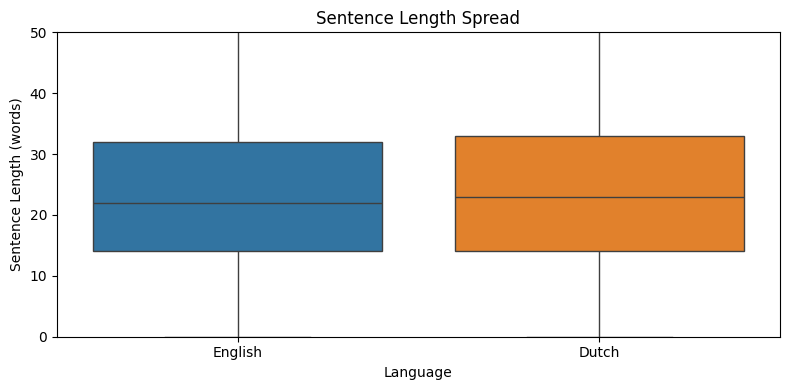

In [36]:
plt.figure(figsize=(8, 4))
sns.boxplot(data=preprocessed_df[['Words_Count_EN', 'Words_Count_NL']])
plt.title('Sentence Length Spread')
plt.xlabel('Language')
plt.xticks([0, 1], ['English', 'Dutch']) 
plt.ylabel('Sentence Length (words)')
plt.ylim(0, 50) 
plt.tight_layout()
plt.show()
plt.close()

## Words

We remove stop words to focus on the most meaningful terms in the text. After filtering, we compute:
- The total number of unique words per language (after stop word removal)
- The top 10 most frequent words
- A word cloud to visualize word frequency

This helps identify key themes and linguistic patterns across languages.

In [38]:
en_stop_words = set(stopwords.words("english"))
nl_stop_words = set(stopwords.words("dutch"))
nl_stop_words.update(["we", "wij", "onze"])

In [39]:
def remove_stop_words(tokens, stopWords):
    return [word for word in tokens if word not in stopWords]

### Unique Words in English

In [41]:
en_sentences = " ".join(preprocessed_df["English"])

In [42]:
all_en_words = remove_stop_words(en_sentences.lower().split(), en_stop_words)

In [43]:
en_unique = set(all_en_words)
len(en_unique)

275564

### Top 10 words in English

In [45]:
# Print top 10 most frequent words
most_common = Counter(all_en_words).most_common(10)
print("\nTop 10 words in English:")
for word, count in most_common:
    print(f"{word}: {count}")


Top 10 words in English:
european: 287363
mr: 194081
would: 165315
also: 161088
-: 149219
must: 141348
commission: 126564
president,: 116784
member: 113364
like: 100083


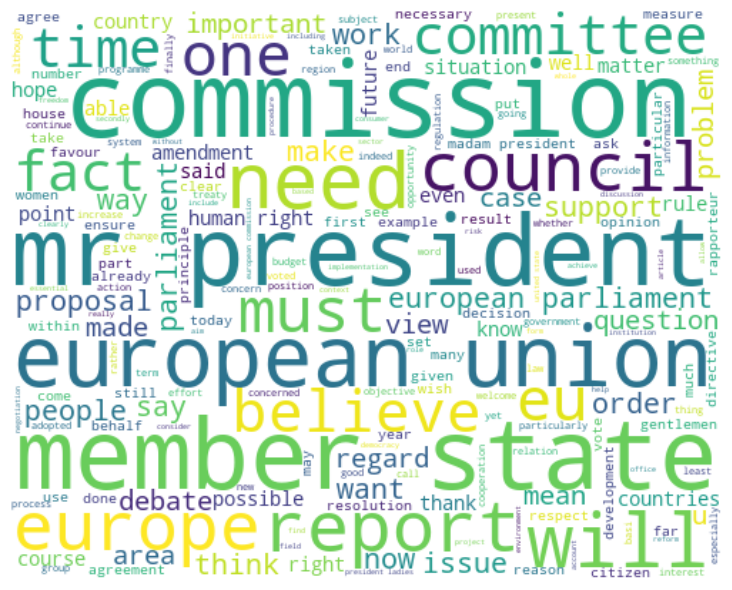

In [46]:
wc = WordCloud(width=500, height=400, background_color="white").generate(en_sentences)
plt.figure(figsize=(13, 6))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.tight_layout()    
plt.show()
plt.close()

### Unique Words in Dutch

In [48]:
nl_sentences = " ".join(preprocessed_df["Dutch"])

In [49]:
all_nl_words = remove_stop_words(nl_sentences.lower().split(), nl_stop_words)

In [50]:
nl_unique = set(all_nl_words)
len(nl_unique)

496241

### Top 10 words in Dutch

In [52]:
# Print top 10 most frequent words
most_common = Counter(all_nl_words).most_common(10)
print("\nTop 10 words in Dutch:")
for word, count in most_common:
    print(f"{word}: {count}")


Top 10 words in Dutch:
europese: 227903
moeten: 208434
commissie: 188583
-: 168179
parlement: 120191
voorzitter,: 118852
mijnheer: 117800
unie: 107445
raad: 84446
alle: 82545


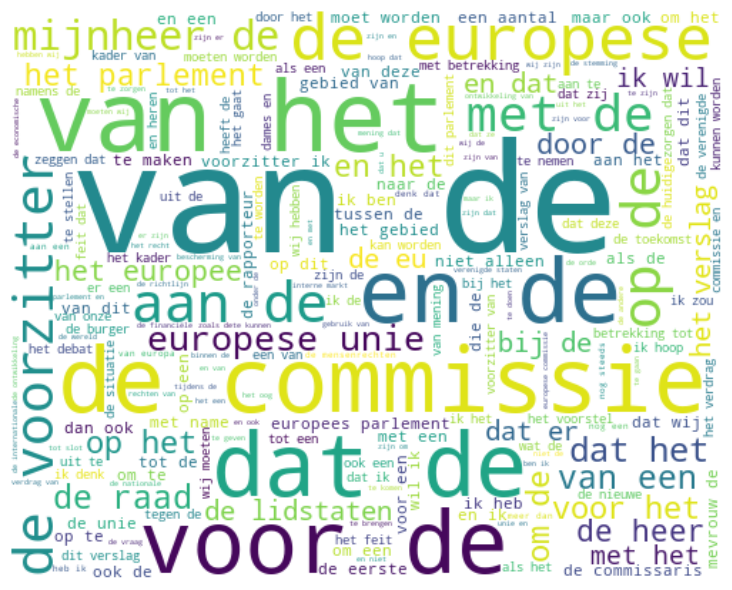

In [53]:
wc = WordCloud(width=500, height=400, background_color="white").generate(nl_sentences)
plt.figure(figsize=(13, 6))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.tight_layout()    
plt.show()
plt.close()

Observations:
High-frequency terms like "european / europese", "commission / commissie", "president / voorzitter," and "mr / mijnheer" reflect formal titles and institutions, which dominate the discourse.

The presence of modal verbs ("would", "must", "moeten") suggests a focus on policy discussion and obligations.

The hyphen (-) is frequent in both languages.